In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import gpytorch
import matplotlib.pyplot as plt
import xarray as xr
import tqdm
import utils as utils
import cartopy.crs as ccrs
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

import fit_spatial_FaIRGP as fairgp
import src.evaluation.visualisation as vis
from src.evaluation.metrics import compute_deterministic_metrics

In [3]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']},}
train_data = fairgp.make_data(train_cfg)

model = fairgp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/all-ssps/SpatialFaIRGP/state_dict.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [4]:
test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical']}}
test_scenarios = fairgp.make_data(test_cfg).scenarios
test_scenarios[0].name = test_scenarios[0].name + '-test'

In [5]:
with torch.no_grad():
    posterior_F = model.forcing_posterior(test_scenarios, diag=False)
posterior_F = posterior_F.reshape(-1, 96, 144)

In [6]:
def encapsulate_as_xarray(data, scenario):
    field = xr.DataArray(data=data.cpu(),
                         dims=['time', 'lat', 'lon'],
                         coords=dict(time=scenario.timesteps.cpu(),
                                     lat=scenario.lat.cpu(),
                                     lon=scenario.lon.cpu()))
    return field

encapsulate = lambda data: encapsulate_as_xarray(data, test_scenarios[0])

In [7]:
xr_forcing = xr.open_dataarray('../data/forcing.nc')
weights = np.cos(np.deg2rad(xr_forcing.lat))
xr_forcing_glob = xr_forcing.weighted(weights).mean(['lat', 'lon'])
pattern_scaling = LinearRegression()
pattern_scaling.fit(xr_forcing_glob.sel(year=slice(1900, 1950)).values[:, None],
                    xr_forcing.sel(year=slice(1900, 1950)).values.reshape(51, -1))

LinearRegression()

In [8]:
mean_fair_forcing = model._compute_forcing_mean(test_scenarios)[:, None]
mean_fair_spatial_forcing = pattern_scaling.predict(mean_fair_forcing).reshape(-1, 96, 144)
# mean_fair_spatial_forcing = mean_fair_forcing[..., None] * torch.ones(165, 96, 144)
foo = posterior_F - mean_fair_forcing.reshape(-1, 1, 1) + mean_fair_spatial_forcing
xr_posterior_F = encapsulate(foo)

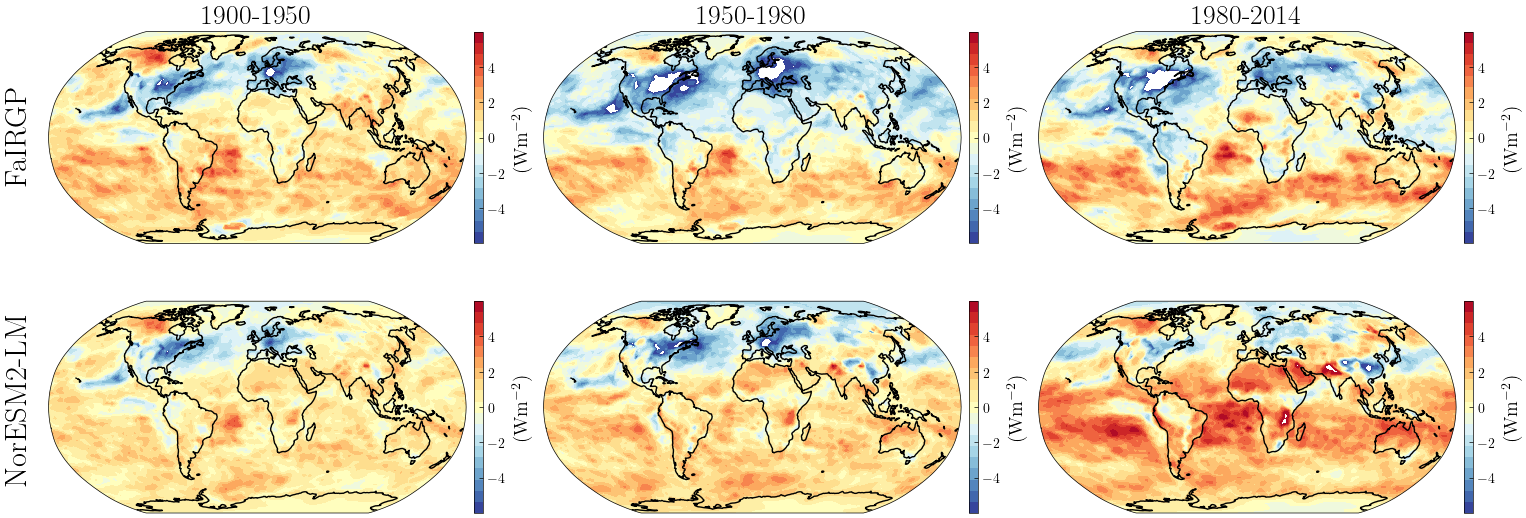

In [38]:
years = [(1900, 1950), (1950, 1980), (1980, 2014)]

ncol = len(years)
vmax = 6

fig, ax = plt.subplots(2, ncol, figsize=(ncol * 5, 2 * 3), subplot_kw={'projection': ccrs.Robinson()})

for i in range(ncol):
    start, end = years[i]
    time_slice = slice(start, end)
    
    _, __, cbar = vis.plot_contourf_on_ax(xr_posterior_F.sel(time=time_slice).mean(dim='time'), 
                                          fig, ax[0, i], colorbar=True, vmax=vmax, cmap='RdYlBu_r')
    cbar.set_label(r'(Wm$^{-2}$)', fontsize=14)
    cbar.set_ticks([-4, -2, 0, 2, 4])
    
    _, __, cbar = vis.plot_contourf_on_ax(xr_forcing.sel(year=time_slice).mean(dim='year'), 
                                          fig, ax[1, i], colorbar=True, vmax=vmax, cmap='RdYlBu_r')
    cbar.set_label(r'(Wm$^{-2}$)', fontsize=14)
    cbar.set_ticks([-4, -2, 0, 2, 4])
    ax[0, i].set_title(f'{start}-{end}', fontsize=20)

fig.text(-0.01, 0.72, 'FaIRGP', ha='center', va='center', rotation='vertical', fontsize=22)
fig.text(-0.01, 0.28, 'NorESM2-LM', ha='center', va='center', rotation='vertical', fontsize=22)

plt.tight_layout()
# plt.savefig('./figures/comparison-spatial-forcing-posterior-paper-figure.png', dpi=200)
plt.show()

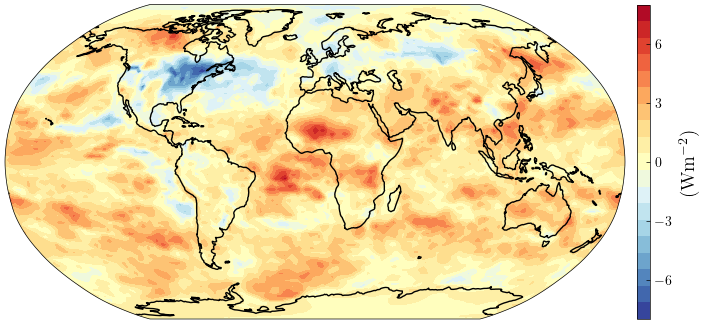

In [9]:
unit_pattern = pattern_scaling.predict(np.ones((1, 1)))
xr_pattern = xr.DataArray(data=unit_pattern.reshape(96, 144),
                          dims=['lat', 'lon'],
                          coords=dict(lat=test_scenarios[0].lat,
                                      lon=test_scenarios[0].lon))

fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={'projection': ccrs.Robinson()})

vmax = 8
_, __, cbar = vis.plot_contourf_on_ax(xr_pattern.clip(max=vmax, min=-vmax), fig, ax,
                                      colorbar=True, cmap='RdYlBu_r')
cbar.set_label(r'(Wm$^{-2}$)', fontsize=14)
cbar.set_ticks([-6, -3, 0, 3, 6], fontsize=14)

# plt.savefig('./figures/unit-forcing-pattern.png', dpi=200)

plt.show()

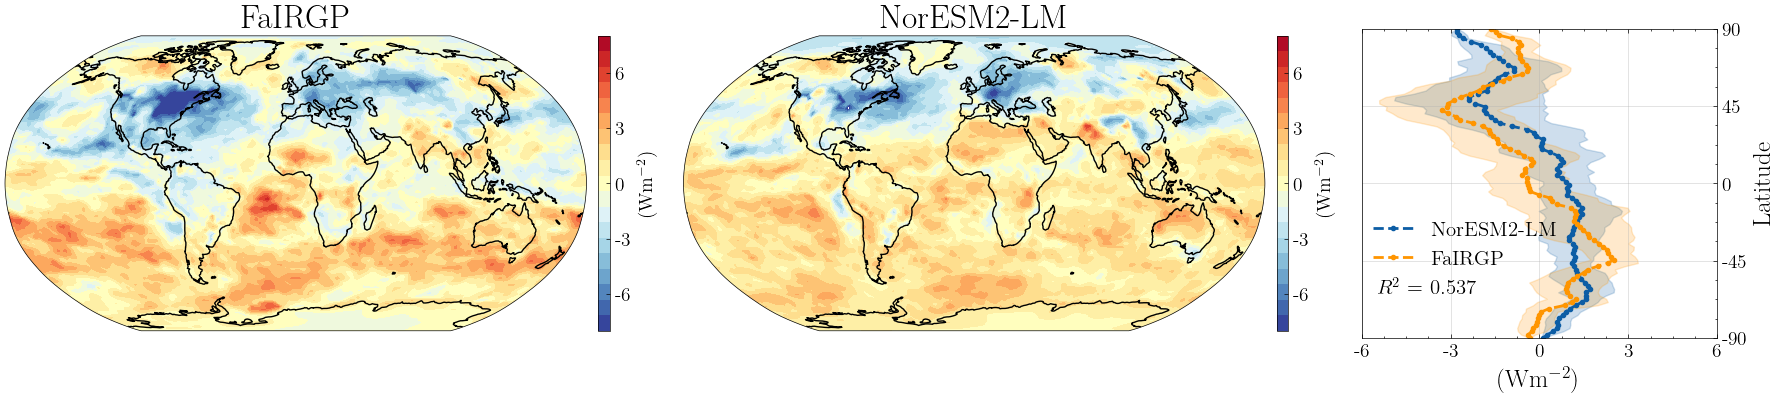

In [39]:
fig = plt.figure(figsize=(18, 4))

start, end = 1960, 1980
time_slice = slice(start, end)
vmax = 8

xr_posterior_F_map = xr_posterior_F.sel(time=time_slice).mean(dim='time').clip(min=-vmax, max=vmax)
xr_forcing_map = xr_forcing.sel(year=time_slice).mean(dim='year')


lat = xr_posterior_F.lat.values

xr_posterior_F_profile_mean = xr_posterior_F_map.mean(dim=['lon']).values
xr_posterior_F_profile_stddev = xr_posterior_F_map.std(dim=['lon']).values

xr_forcing_profile_mean = xr_forcing_map.mean(dim=['lon']).values
xr_forcing_profile_stddev = xr_forcing_map.std(dim=['lon']).values

R2 = r2_score(xr_forcing_profile_mean, xr_posterior_F_profile_mean)

nrows = 9
ncols = 8

mapax1 = plt.subplot2grid((nrows, ncols), (0, 0), colspan=3, rowspan=nrows, projection=ccrs.Robinson())
mapax2 = plt.subplot2grid((nrows, ncols), (0, 3), colspan=3, rowspan=nrows, projection=ccrs.Robinson())
barax = plt.subplot2grid((nrows, ncols), (0, 6), colspan=2, rowspan=nrows)


_, __, cbar = vis.plot_contourf_on_ax(xr_posterior_F_map, 
                                      fig, mapax1, colorbar=True, vmax=vmax, cmap='RdYlBu_r')
cbar.set_label(r'(Wm$^{-2}$)', fontsize=14)
cbar.set_ticks([-6, -3, 0, 3, 6])
cbar.set_ticklabels([-6, -3, 0, 3, 6], fontsize=14)
mapax1.set_title('FaIRGP', fontsize=24)


_, __, cbar = vis.plot_contourf_on_ax(xr_forcing_map, 
                                      fig, mapax2, colorbar=True, vmax=vmax, cmap='RdYlBu_r')
cbar.set_label(r'(Wm$^{-2}$)', fontsize=14)
cbar.set_ticks([-6, -3, 0, 3, 6])
cbar.set_ticklabels([-6, -3, 0, 3, 6], fontsize=14)
mapax2.set_title('NorESM2-LM', fontsize=24)


im = barax.plot(xr_forcing_profile_mean, lat, '--.', lw=2, color='C0', label='NorESM2-LM')
barax.fill_betweenx(lat,
                    xr_forcing_profile_mean - xr_forcing_profile_stddev,
                    xr_forcing_profile_mean + xr_forcing_profile_stddev,
                    color='C0', alpha=0.2)
im = barax.plot(xr_posterior_F_profile_mean, lat, '--.', lw=2, color='C2', label='FaIRGP')
barax.fill_betweenx(lat,
                    xr_posterior_F_profile_mean - xr_posterior_F_profile_stddev,
                    xr_posterior_F_profile_mean + xr_posterior_F_profile_stddev,
                    color='C2', alpha=0.2)

barax.yaxis.tick_right()
barax.yaxis.set_label_position("right")
barax.grid(alpha=0.5)
barax.set_xlim(-6, 6)
barax.set_ylim(-90, 90)
barax.set_yticks([-90, -45, 0, 45, 90])
barax.set_yticklabels([-90, -45, 0, 45, 90], fontsize=14)
barax.set_xticks([-6, -3, 0, 3, 6])
barax.set_xticklabels([-6, -3, 0, 3, 6], fontsize=14)
barax.legend(fontsize=15, bbox_to_anchor=(0.6, 0.44))
barax.set_xlabel(r'(Wm$^{-2}$)', fontsize=18)
barax.set_ylabel('Latitude', fontsize=18)
barax.annotate(r"$R^2$ = {:.3f}".format(R2), (-5.5, -64), fontsize=15)

plt.tight_layout()
plt.savefig('./figures/comparison-spatial-forcing-posterior-1960-1980-paper-figure.png', dpi=200)
plt.show()

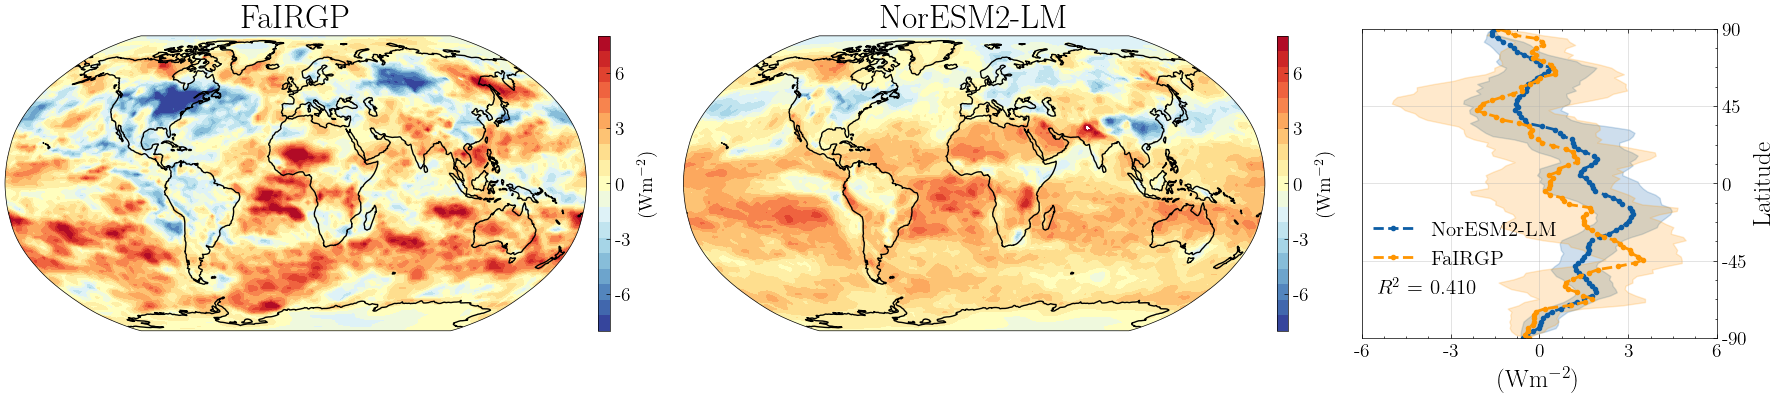

In [40]:
fig = plt.figure(figsize=(18, 4))

start, end = 1980, 2014
time_slice = slice(start, end)
vmax = 8

xr_posterior_F_map = xr_posterior_F.sel(time=time_slice).mean(dim='time').clip(min=-vmax, max=vmax)
xr_forcing_map = xr_forcing.sel(year=time_slice).mean(dim='year')


lat = xr_posterior_F.lat.values

xr_posterior_F_profile_mean = xr_posterior_F_map.mean(dim=['lon']).values
xr_posterior_F_profile_stddev = xr_posterior_F_map.std(dim=['lon']).values

xr_forcing_profile_mean = xr_forcing_map.mean(dim=['lon']).values
xr_forcing_profile_stddev = xr_forcing_map.std(dim=['lon']).values

R2 = r2_score(xr_forcing_profile_mean, xr_posterior_F_profile_mean)

nrows = 9
ncols = 8

mapax1 = plt.subplot2grid((nrows, ncols), (0, 0), colspan=3, rowspan=nrows, projection=ccrs.Robinson())
mapax2 = plt.subplot2grid((nrows, ncols), (0, 3), colspan=3, rowspan=nrows, projection=ccrs.Robinson())
barax = plt.subplot2grid((nrows, ncols), (0, 6), colspan=2, rowspan=nrows)


_, __, cbar = vis.plot_contourf_on_ax(xr_posterior_F_map, 
                                      fig, mapax1, colorbar=True, vmax=vmax, cmap='RdYlBu_r')
cbar.set_label(r'(Wm$^{-2}$)', fontsize=14)
cbar.set_ticks([-6, -3, 0, 3, 6])
cbar.set_ticklabels([-6, -3, 0, 3, 6], fontsize=14)
mapax1.set_title('FaIRGP', fontsize=24)


_, __, cbar = vis.plot_contourf_on_ax(xr_forcing_map, 
                                      fig, mapax2, colorbar=True, vmax=vmax, cmap='RdYlBu_r')
cbar.set_label(r'(Wm$^{-2}$)', fontsize=14)
cbar.set_ticks([-6, -3, 0, 3, 6])
cbar.set_ticklabels([-6, -3, 0, 3, 6], fontsize=14)
mapax2.set_title('NorESM2-LM', fontsize=24)



im = barax.plot(xr_forcing_profile_mean, lat, '--.', lw=2, color='C0', label='NorESM2-LM')
barax.fill_betweenx(lat,
                    xr_forcing_profile_mean - xr_forcing_profile_stddev,
                    xr_forcing_profile_mean + xr_forcing_profile_stddev,
                    color='C0', alpha=0.2)
im = barax.plot(xr_posterior_F_profile_mean, lat, '--.', lw=2, color='C2', label='FaIRGP')
barax.fill_betweenx(lat,
                    xr_posterior_F_profile_mean - xr_posterior_F_profile_stddev,
                    xr_posterior_F_profile_mean + xr_posterior_F_profile_stddev,
                    color='C2', alpha=0.2)

barax.yaxis.tick_right()
barax.yaxis.set_label_position("right")
barax.grid(alpha=0.5)
barax.set_xlim(-6, 6)
barax.set_ylim(-90, 90)
barax.set_yticks([-90, -45, 0, 45, 90])
barax.set_yticklabels([-90, -45, 0, 45, 90], fontsize=14)
barax.set_xticks([-6, -3, 0, 3, 6])
barax.set_xticklabels([-6, -3, 0, 3, 6], fontsize=14)
barax.legend(fontsize=15, bbox_to_anchor=(0.6, 0.44))
barax.set_xlabel(r'(Wm$^{-2}$)', fontsize=18)
barax.set_ylabel('Latitude', fontsize=18)
barax.annotate(r"$R^2$ = {:.3f}".format(R2), (-5.5, -64), fontsize=15)

plt.tight_layout()
# plt.savefig('./figures/comparison-spatial-forcing-posterior-1980-2014-paper-figure.png', dpi=200)
plt.show()

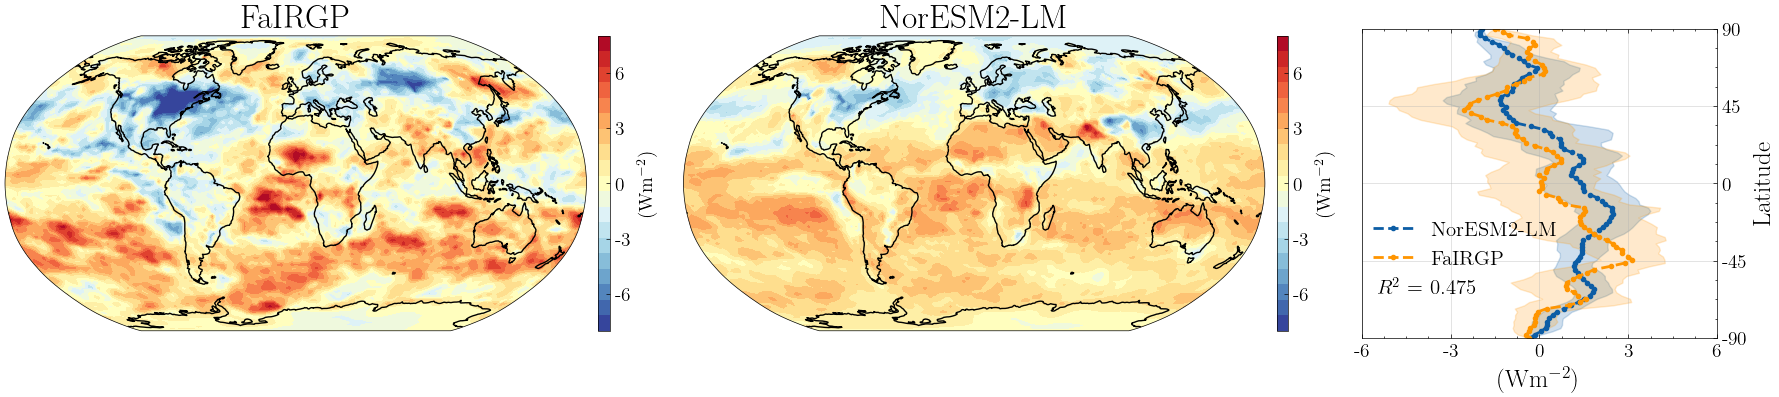

In [41]:
fig = plt.figure(figsize=(18, 4))

start, end = 1960, 2014
time_slice = slice(start, end)
vmax = 8

xr_posterior_F_map = xr_posterior_F.sel(time=time_slice).mean(dim='time').clip(min=-vmax, max=vmax)
xr_forcing_map = xr_forcing.sel(year=time_slice).mean(dim='year')


lat = xr_posterior_F.lat.values

xr_posterior_F_profile_mean = xr_posterior_F_map.mean(dim=['lon']).values
xr_posterior_F_profile_stddev = xr_posterior_F_map.std(dim=['lon']).values

xr_forcing_profile_mean = xr_forcing_map.mean(dim=['lon']).values
xr_forcing_profile_stddev = xr_forcing_map.std(dim=['lon']).values

R2 = r2_score(xr_forcing_profile_mean, xr_posterior_F_profile_mean)

nrows = 9
ncols = 8

mapax1 = plt.subplot2grid((nrows, ncols), (0, 0), colspan=3, rowspan=nrows, projection=ccrs.Robinson())
mapax2 = plt.subplot2grid((nrows, ncols), (0, 3), colspan=3, rowspan=nrows, projection=ccrs.Robinson())
barax = plt.subplot2grid((nrows, ncols), (0, 6), colspan=2, rowspan=nrows)


_, __, cbar = vis.plot_contourf_on_ax(xr_posterior_F_map, 
                                      fig, mapax1, colorbar=True, vmax=vmax, cmap='RdYlBu_r')
cbar.set_label(r'(Wm$^{-2}$)', fontsize=14)
cbar.set_ticks([-6, -3, 0, 3, 6])
cbar.set_ticklabels([-6, -3, 0, 3, 6], fontsize=14)
mapax1.set_title('FaIRGP', fontsize=24)


_, __, cbar = vis.plot_contourf_on_ax(xr_forcing_map, 
                                      fig, mapax2, colorbar=True, vmax=vmax, cmap='RdYlBu_r')
cbar.set_label(r'(Wm$^{-2}$)', fontsize=14)
cbar.set_ticks([-6, -3, 0, 3, 6])
cbar.set_ticklabels([-6, -3, 0, 3, 6], fontsize=14)
mapax2.set_title('NorESM2-LM', fontsize=24)



im = barax.plot(xr_forcing_profile_mean, lat, '--.', lw=2, color='C0', label='NorESM2-LM')
barax.fill_betweenx(lat,
                    xr_forcing_profile_mean - xr_forcing_profile_stddev,
                    xr_forcing_profile_mean + xr_forcing_profile_stddev,
                    color='C0', alpha=0.2)
im = barax.plot(xr_posterior_F_profile_mean, lat, '--.', lw=2, color='C2', label='FaIRGP')
barax.fill_betweenx(lat,
                    xr_posterior_F_profile_mean - xr_posterior_F_profile_stddev,
                    xr_posterior_F_profile_mean + xr_posterior_F_profile_stddev,
                    color='C2', alpha=0.2)

barax.yaxis.tick_right()
barax.yaxis.set_label_position("right")
barax.grid(alpha=0.5)
barax.set_xlim(-6, 6)
barax.set_ylim(-90, 90)
barax.set_yticks([-90, -45, 0, 45, 90])
barax.set_yticklabels([-90, -45, 0, 45, 90], fontsize=14)
barax.set_xticks([-6, -3, 0, 3, 6])
barax.set_xticklabels([-6, -3, 0, 3, 6], fontsize=14)
barax.legend(fontsize=15, bbox_to_anchor=(0.6, 0.44))
barax.set_xlabel(r'(Wm$^{-2}$)', fontsize=18)
barax.set_ylabel('Latitude', fontsize=18)
barax.annotate(r"$R^2$ = {:.3f}".format(R2), (-5.5, -64), fontsize=15)

plt.tight_layout()
# plt.savefig('./figures/comparison-spatial-forcing-posterior-1960-2014-paper-figure.png', dpi=200)
plt.show()

In [21]:
metrics8014 = compute_deterministic_metrics(torch.from_numpy(xr_posterior_F_profile_mean).float(),
                                        torch.from_numpy(xr_forcing_profile_mean).float())

In [27]:

coefficient_of_dermination = r2_score(xr_forcing_profile_mean, xr_posterior_F_profile_mean)

In [28]:
coefficient_of_dermination

0.41016721529800904

In [26]:
scores = pd.DataFrame([metrics_6080, metrics8014], index=['1960-1980', '1980-2014'])
scores.columns = ['Bias', 'RMSE', 'MAE', 'Corr']
scores = scores[['RMSE', 'MAE', 'Bias', 'Corr']]
scores

,RMSE,MAE,Bias,Corr
1960-1980,0.921674,0.819400,-0.247958,0.801506
1980-2014,0.967975,0.804245,-0.314347,0.733911


## SSP245

In [41]:
test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp245']}}
test_scenarios = fairgp.make_data(test_cfg).scenarios
test_scenarios[0].name = test_scenarios[0].name + '-test'

In [42]:
with torch.no_grad():
    posterior_F = model.forcing_posterior(test_scenarios, diag=False)
posterior_F = posterior_F.reshape(-1, 96, 144)

In [43]:
def encapsulate_as_xarray(data, scenario):
    field = xr.DataArray(data=data.cpu(),
                         dims=['time', 'lat', 'lon'],
                         coords=dict(time=scenario.timesteps.cpu(),
                                     lat=scenario.lat.cpu(),
                                     lon=scenario.lon.cpu()))
    return field

encapsulate = lambda data: encapsulate_as_xarray(data, test_scenarios[0])
xr_posterior_F = encapsulate(posterior_F)

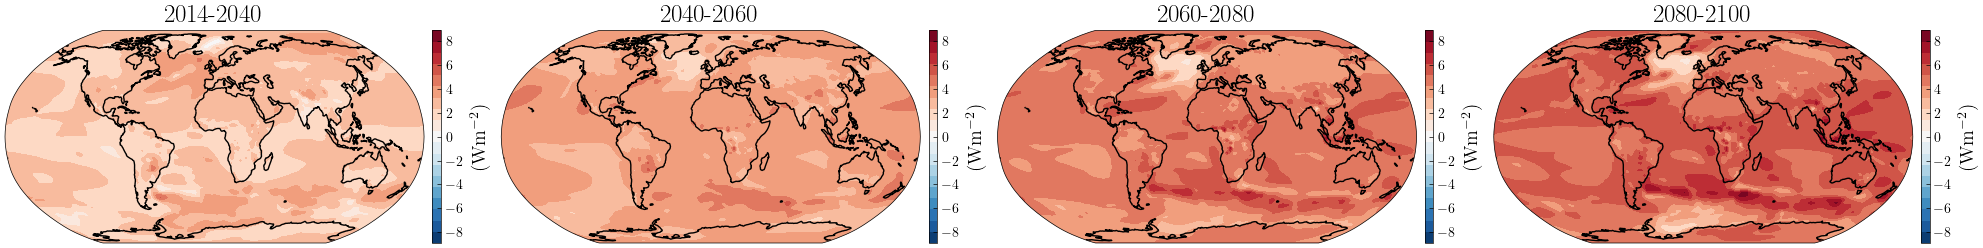

In [45]:
years = [(2014, 2040), (2040, 2060), (2060, 2080), (2080, 2100)]

ncol = len(years)
vmax = posterior_F.max()

fig, ax = plt.subplots(1, ncol, figsize=(ncol * 5, 6), subplot_kw={'projection': ccrs.Robinson()})

for i in range(ncol):
    start, end = years[i]
    time_slice = slice(start, end)
    
    _, __, cbar = vis.plot_contourf_on_ax(xr_posterior_F.sel(time=time_slice).mean(dim='time'), 
                                          fig, ax[i], colorbar=True, vmax=vmax)
    cbar.set_label(r'(Wm$^{-2}$)', fontsize=14)
    cbar.set_ticks([-8, -6, -4, -2, 0, 2, 4, 6, 8])
    ax[i].set_title(f'{start}-{end}', fontsize=18)
    
plt.tight_layout()
plt.show()

## SSP126

In [51]:
test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp126']}}
test_scenarios = fairgp.make_data(test_cfg).scenarios
test_scenarios[0].name = test_scenarios[0].name + '-test'

In [52]:
with torch.no_grad():
    posterior_F = model.forcing_posterior(test_scenarios, diag=False)
posterior_F = posterior_F.reshape(-1, 96, 144)

In [53]:
def encapsulate_as_xarray(data, scenario):
    field = xr.DataArray(data=data.cpu(),
                         dims=['time', 'lat', 'lon'],
                         coords=dict(time=scenario.timesteps.cpu(),
                                     lat=scenario.lat.cpu(),
                                     lon=scenario.lon.cpu()))
    return field

encapsulate = lambda data: encapsulate_as_xarray(data, test_scenarios[0])
xr_posterior_F = encapsulate(posterior_F)

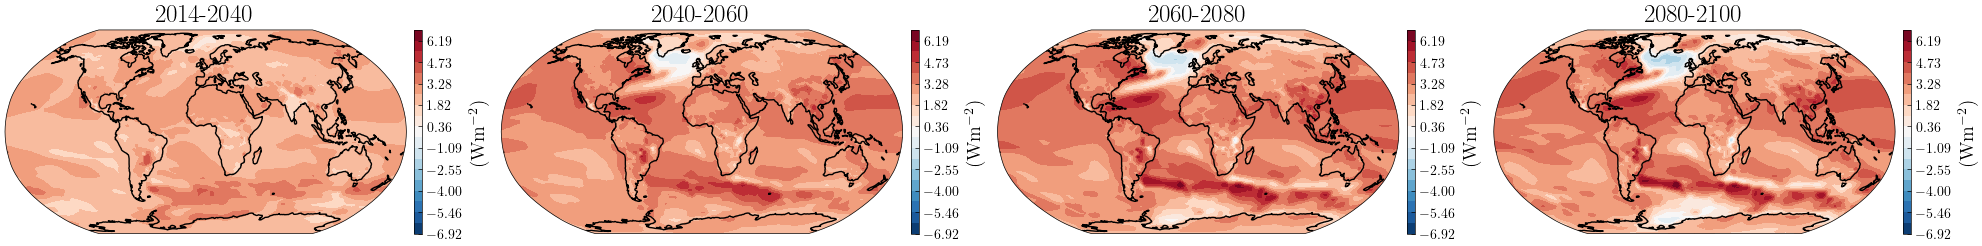

In [54]:
years = [(2014, 2040), (2040, 2060), (2060, 2080), (2080, 2100)]

ncol = len(years)
vmax = posterior_F.max()

fig, ax = plt.subplots(1, ncol, figsize=(ncol * 5, 6), subplot_kw={'projection': ccrs.Robinson()})

for i in range(ncol):
    start, end = years[i]
    time_slice = slice(start, end)
    
    _, __, cbar = vis.plot_contourf_on_ax(xr_posterior_F.sel(time=time_slice).mean(dim='time'), 
                                          fig, ax[i], colorbar=True, vmax=vmax)
    cbar.set_label(r'(Wm$^{-2}$)', fontsize=14)
#     cbar.set_ticks([-8, -6, -4, -2, 0, 2, 4, 6, 8])
    ax[i].set_title(f'{start}-{end}', fontsize=18)
    
plt.tight_layout()
plt.show()

## SSP585

In [46]:
test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp585']}}
test_scenarios = fairgp.make_data(test_cfg).scenarios
test_scenarios[0].name = test_scenarios[0].name + '-test'

In [47]:
with torch.no_grad():
    posterior_F = model.forcing_posterior(test_scenarios, diag=False)
posterior_F = posterior_F.reshape(-1, 96, 144)

In [48]:
def encapsulate_as_xarray(data, scenario):
    field = xr.DataArray(data=data.cpu(),
                         dims=['time', 'lat', 'lon'],
                         coords=dict(time=scenario.timesteps.cpu(),
                                     lat=scenario.lat.cpu(),
                                     lon=scenario.lon.cpu()))
    return field

encapsulate = lambda data: encapsulate_as_xarray(data, test_scenarios[0])
xr_posterior_F = encapsulate(posterior_F)

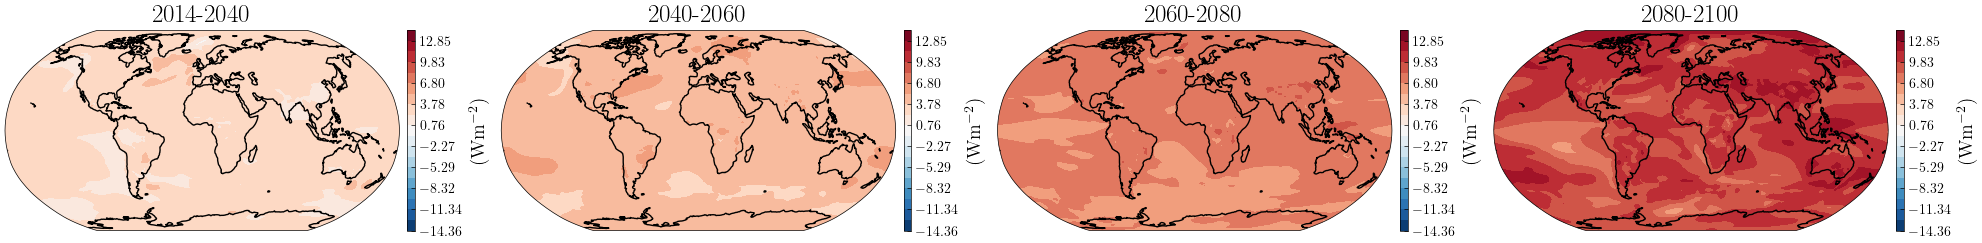

In [50]:
years = [(2014, 2040), (2040, 2060), (2060, 2080), (2080, 2100)]

ncol = len(years)
vmax = posterior_F.max()

fig, ax = plt.subplots(1, ncol, figsize=(ncol * 5, 6), subplot_kw={'projection': ccrs.Robinson()})

for i in range(ncol):
    start, end = years[i]
    time_slice = slice(start, end)
    
    _, __, cbar = vis.plot_contourf_on_ax(xr_posterior_F.sel(time=time_slice).mean(dim='time'), 
                                          fig, ax[i], colorbar=True, vmax=vmax)
    cbar.set_label(r'(Wm$^{-2}$)', fontsize=14)
#     cbar.set_ticks([-8, -6, -4, -2, 0, 2, 4, 6, 8])
    ax[i].set_title(f'{start}-{end}', fontsize=18)
    
plt.tight_layout()
plt.show()